# Imports

In [550]:
import numpy as np
import pandas as pd
from scipy import sparse
import scipy.linalg as spla

import multiprocessing
from multiprocessing import process
from multiprocessing import Pool 

import time
import itertools
import math

import matplotlib.pyplot as plt
import seaborn as sns

# Declarations

In [551]:
random_seed = 42
regression_matrix_rows = 1000
regression_matrix_cols = 840
density = 0.1

# fix the random seed
np.random.seed(random_seed)

# get the matrices
A = np.random.uniform(0, 1, size=(regression_matrix_rows, regression_matrix_cols))
z = sparse.random(regression_matrix_cols, 1, density=0.01).toarray()
w = np.random.uniform (0,  0.2, size=(regression_matrix_rows, 1))
b = np.matmul(A, z) + w

print(f"Shape of A: {A.shape}\nShape of B: {b.shape} ")

Shape of A: (1000, 840)
Shape of B: (1000, 1) 


# Store Data to Compare

In [552]:
df = pd.DataFrame(
    columns=["Number of Stages", "Number of Agents", "R", "Time"]
)

# Helper Functions

In [553]:
def subproblem(A, b):
    x = np.matmul((np.linalg.pinv(A)), b)
    r = b - np.matmul(A, x)
    
    return (x, r)


def processed_wrapped_parameters(args):
    return subproblem(*args)


def update_x_and_R(x, ret):
    sm = sum([tup[1] for tup in ret])
    R = [sm] * len(ret)
    
    new_x = []
    for i, j in zip(x, ret):
        if type(i) == int:
            new_x.append(j[0])
        else:
            new_x.append(i + j[0])
            
    return new_x, R


def formulate_x(x):
    new_x = []
    
    for element in x:
        new_x.append(element.tolist())
        
    flattened = list(itertools.chain.from_iterable(new_x))
    
    return list(itertools.chain.from_iterable(flattened))


def calculate_squared_distance(r):
    r = list(itertools.chain.from_iterable(r))
    
    return math.sqrt(sum([i*i for i in r]))

# Implement PRP

In [554]:
def PRP(A, b, p, k):
    A = np.split(A, p, axis=1)
    b = [b/p for i in range(p)]
    x = [0] * p
    w = 1/p
    R = [i for i in b]
    
    for stage in range(1, k+1):
        new_R = [i*w for i in R]
        
        # multiprocessing part
        parameters_list = [[i, j] for i, j in zip(A, new_R)]
        pool = Pool(p)
        ret = pool.map(processed_wrapped_parameters, parameters_list)
        pool.close()
        pool.join()
        
        x, R = update_x_and_R(x, ret)
        
    x = formulate_x(x)
    
    return x, sum(R)

In [555]:
p = [2, 3, 4, 5, 6, 7, 8]
k = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

for pools in p:
    for stages in k:
        start = time.time()
        x, r = PRP(A, b, pools, stages)
        end = time.time()
        
        df.loc[len(df)] = [stages, pools, calculate_squared_distance(r), end-start]

In [556]:
df

,Number of Stages,Number of Agents,R,Time
0,5.0,2.0,2.401275,0.983791
1,10.0,2.0,1.628377,1.859581
2,15.0,2.0,1.358463,2.766380
3,20.0,2.0,1.223577,3.807568
4,25.0,2.0,1.144652,4.473567
...,...,...,...,...
65,30.0,8.0,2.370344,32.581832
66,35.0,8.0,2.186438,30.833900
67,40.0,8.0,2.047352,34.190492
68,45.0,8.0,1.938930,46.048877


# Generate Graphs

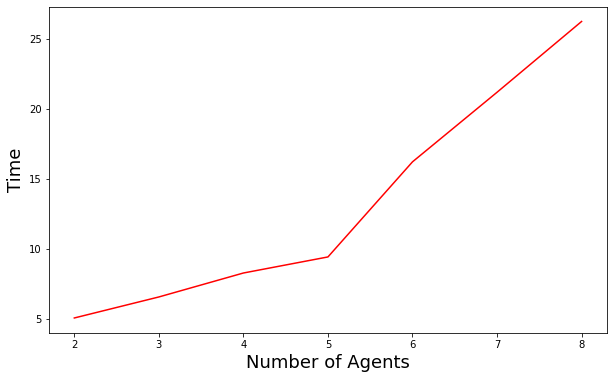

In [557]:
temp = df[["Number of Agents", "Time"]].groupby(["Number of Agents"]).mean()
temp['Number of Agents'] = temp.index

plt.figure(figsize=(10, 6))
plt.xlabel("Number of Agents", fontsize=18)
plt.ylabel("Time", fontsize=18)
plt.plot(temp["Number of Agents"], temp["Time"], color='r')
plt.show()

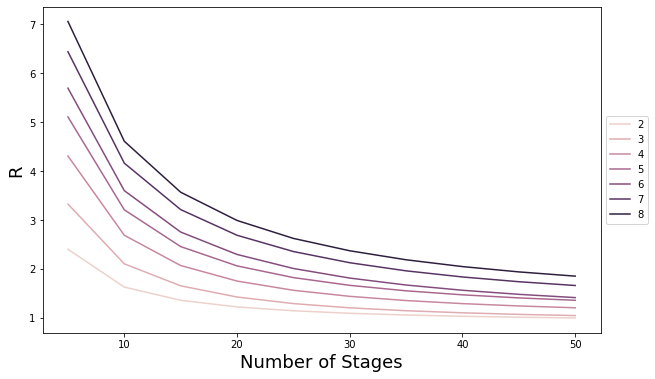

In [559]:
plt.figure(figsize=(10, 6))
plt.xlabel("Number of Stages", fontsize=18)
plt.ylabel("R", fontsize=18)
ax = sns.lineplot(x=df["Number of Stages"], y=df["R"], hue=df["Number of Agents"])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()